I've been thinking a lot lately about mechanistic interpretability, that is, how to make the internal workings of neural nets transparent to humans. For this post, let's explore one idea in this direction: using a convolutional net to predict the inputs and outputs of a different, target network, based on its internal activations. To keep things simple, for our target network we'll use a binary operation learner and train it on modulo two addition. First we'll import some libraries and set up the network architecture.

In [1]:
import numpy as np
import pandas as pd
import sys
import json
import pickle

# the number of layers must be at least three
num_layers    = 7
# number of neurons in the hidden, input, and output layers
num_hidden    = num_layers-2
# modulus for the binary arithmetic operation
modulus       = 2
num_input     = 2*modulus
num_output    = modulus
layers_list   = list()
for i in range(num_layers):
    if (i==0):
        layer = np.zeros((1,num_input))
    elif (i==(num_layers-1)):
        layer = np.zeros((1,num_output))
    else:
        layer = np.zeros((1,num_hidden))
    layers_list.append(layer)

weights_list = list()
weight_corrects_list = list()
np.random.seed(4)
for i in range(num_layers-1):
    if (i==0):
        weights = 2.0*np.random.random((num_input,num_hidden))
    elif (i==(num_layers-2)):
        weights = 2.0*np.random.random((num_hidden,num_output))-1.0
    else:
        weights = 2.0*np.random.random((num_hidden,num_hidden))-1.0
    weights_list.append(weights)
    weight_corrects_list.append(np.zeros((num_hidden,num_hidden)))

Now let's define the usual activation functions as well as set up the training and test sets. We will one-hot encode the inputs and outputs.

In [3]:
# layer_type = 1 will return tanh (or its derivative)
# layer_type = 2 will return softmax (or its derivative)
def activ_func(x,layer_type):
    if (layer_type==1):
        return np.tanh(x)
    elif (layer_type==2):
        return np.exp(x)/np.exp(x).sum()

def activ_deriv(x,layer_type):
    if (layer_type==1):
        return 1.0-np.tanh(x)**2.0
    elif (layer_type==2):
        soft_max = np.exp(x)/np.exp(x).sum()
        return soft_max*(1.0-soft_max)
    
num_train = 10000
num_test  = 10000
Xtrain_pre = np.random.randint(0,modulus,(num_train,2))
Xtest_pre  = np.random.randint(0,modulus,(num_test,2))
ytrain_pre = np.mod(Xtrain_pre[:,0]+Xtrain_pre[:,1],modulus)
ytest_pre  = np.mod(Xtest_pre[:,0]+Xtest_pre[:,1],modulus)
Xtrain = np.zeros((num_train,num_input))
Xtest  = np.zeros((num_test,num_input))
for i in range(num_train):
    Xtrain[i,Xtrain_pre[i,0]]=1.0
    Xtrain[i,Xtrain_pre[i,1]+modulus]=1.0
for i in range(num_test):
    Xtest[i,Xtest_pre[i,0]]=1.0
    Xtest[i,Xtest_pre[i,1]+modulus]=1.0

# one-hot encode the target outputs
ytrain = np.zeros((num_train,modulus))
ytest  = np.zeros((num_test,modulus))
for i in range(num_train):
    ytrain[i,ytrain_pre[i]]=1.0
for i in range(num_test):
    ytest[i,ytest_pre[i]]=1.0

With these in place we can train the model.

In [5]:
alpha     = 0.0001
err_tol   = 0.1
max_iter  = 500
iter_num  = 0
err       = 1.e5
while ((iter_num<max_iter)&(err>err_tol)):
    err = 0.0
    for i in range(num_train):
        layers_list[0] = Xtrain[i]
        for j in range(1,num_layers-1):
            layers_list[j] = \
                    activ_func(np.matmul(layers_list[j-1], \
                               weights_list[j-1]),1)
        layers_list[num_layers-1] = \
            activ_func(np.matmul(layers_list[num_layers-2], \
                       weights_list[num_layers-2]),2)

        # backprop step
        # form the diagonal activation derivative matrices
        delta = (layers_list[num_layers-1]-ytrain[i])
        delta = delta.reshape(1,ytrain.shape[1])
        diag_activs = list()
        # NB: the ith entry in diag_activs corresponds to the
        #     (i+1)th layer, so entry 0 is for the 1st layer, etc
        for j in range(1,num_layers-1):
            activ_der = activ_deriv(layers_list[j],1)
            diag_mat = np.diag(activ_der)
            diag_activs.append(diag_mat)

        activ_der = activ_deriv(layers_list[num_layers-1],2)
        diag_mat = np.diag(activ_der)
        diag_activs.append(diag_mat)
        
        # form the products of the weights and diagonals
        mat_prods = list()
        mat_prods.append(np.matmul(delta,diag_activs[num_layers-2]))
        for j in range(num_layers-2):
            mat1 = weights_list[num_layers-2-j].T
            mat2 = diag_activs[num_layers-3-j]
            new_mat = np.matmul(mat1,mat2)
            tot_mat = np.matmul(mat_prods[j],new_mat)
            mat_prods.append(tot_mat)

        for j in range(len(weights_list)):
            weight_corrects_list[j] = \
                -alpha*np.outer(layers_list[num_layers-2-j], \
                                mat_prods[j])
            weights_list[num_layers-2-j] += weight_corrects_list[j]

        err += (delta**2.0).sum()

    err /= num_train
    #print(iter_num,err)

    iter_num += 1

print('converged on iteration: ',iter_num)
print('training set error: ',err)

converged on iteration:  13
training set error:  0.07214775530824573


Let's see how well the model does on the test set.

In [6]:
# check how well the model predicts out of sample
num_correct = 0.0
for i in range(num_test):
    layers_list[0] = Xtest[i]
    for j in range(1,num_layers-1):
        layers_list[j] = \
                activ_func(np.matmul(layers_list[j-1], \
                           weights_list[j-1]),1)
    layers_list[num_layers-1] = \
        activ_func(np.matmul(layers_list[num_layers-2], \
                   weights_list[num_layers-2]),2)

    pred_answer = layers_list[num_layers-1].argmax()
    true_answer = ytest[i].argmax()

    if (pred_answer==true_answer):
        num_correct += 1.0

percent_correct = (num_correct/num_test)*100.0
print('percent correct out of sample: ',percent_correct)

percent correct out of sample:  100.0


Good, it's learned how to do binary addition correctly. We can save the parameters for later like so.

In [7]:
with open("weights.pkl", "wb") as f:
    pickle.dump(weights_list,f)
with open("Xtest.pkl","wb") as f:
    pickle.dump(Xtest,f)
with open("ytest.pkl","wb") as f:
    pickle.dump(ytest,f)

Now that we have a working model, we need to save its activations to be viewed by the convolutional net and put its inputs/outputs in the correct format: Both the inputs and outputs of the modular addition network will be outputs for our the convolutional network.

In [8]:
with open("weights.pkl", "rb") as f:
    weights_list = pickle.load(f)
with open("Xtest.pkl", "rb") as f:
    Xtest = pickle.load(f)
with open("ytest.pkl", "rb") as f:
    ytest = pickle.load(f)

num_weights = len(weights_list)
num_input   = weights_list[0].shape[0]
num_output  = weights_list[num_weights-1].shape[1]
num_hidden  = weights_list[0].shape[1]
num_layers  = num_weights+1

layers_list = list()
for i in range(num_weights):
    layer = np.zeros((1,weights_list[i].shape[0]))
    layers_list.append(layer)
layer = np.zeros((1,num_output))
layers_list.append(layer)

def activ_func(x,layer_type):
    if (layer_type==1):
        return np.tanh(x)
    elif (layer_type==2):
        return np.exp(x)/np.exp(x).sum()

activ_mat  = np.zeros((num_hidden,num_hidden))
X_conv     = np.zeros((Xtest.shape[0],num_hidden,num_hidden))
y_conv     = np.zeros((Xtest.shape[0],num_input+num_output))
num_correct = 0
for i in range(Xtest.shape[0]):
    layers_list[0] = Xtest[i]
    for j in range(1,num_layers-1):
        layers_list[j] = activ_func(np.matmul(layers_list[j-1], \
                         weights_list[j-1]),1).round(decimals=2)
    layers_list[num_layers-1] = \
            activ_func(np.matmul(layers_list[num_layers-2], \
            weights_list[num_layers-2]),2).round(decimals=2)

    y_conv[i,0:num_input] = Xtest[i]
    y_conv[i,num_input:num_input+num_output]= \
            layers_list[num_layers-1]

    for j in range(num_hidden):
        activ_mat[j] = layers_list[j+1]
    X_conv[i] = activ_mat

    num_pred = layers_list[num_layers-1].argmax()
    num_test = ytest[i].argmax()

    if (num_pred==num_test):
        num_correct += 1.0

percent_correct = (num_correct/Xtest.shape[0])*100.0
print("percent correct on test set: ",percent_correct)

# save the weights and the test data
X_conv = np.asanyarray(X_conv,dtype=object)
y_conv = np.asanyarray(y_conv,dtype=object)
np.savez("X_conv",X_conv)
np.savez("y_conv",y_conv)

percent correct on test set:  100.0


That last print statement was just to make sure that we have in fact saved the correct activations! It's time to introduce our convolutional net and see if can learn the inputs and outputs from the activations of the target network.

In [10]:
np.random.seed(3)

# load X_conv and y_conv
Xconv_load   = np.load('X_conv.npz',allow_pickle=True)
yconv_load   = np.load('y_conv.npz',allow_pickle=True)

Xconv = Xconv_load['arr_0'].astype('float64')
yconv = yconv_load['arr_0'].astype('float64')

num_total = Xconv.shape[0]
num_soft_max = int(yconv.shape[1]/3)

for i in range(num_total):
   max_ind = yconv[i,2*num_soft_max:3*num_soft_max].argmax()
   yconv[i,2*num_soft_max:3*num_soft_max] = 0.0
   yconv[i,2*num_soft_max+max_ind] = 1.0

# set up the training and test samples
percent_train = 0.9
num_train = int(np.round(num_total*percent_train))
num_test  = num_total-num_train
Xtrain    = Xconv[0:num_train]
ytrain    = yconv[0:num_train]
Xtest     = Xconv[num_train:num_train+num_test]
ytest     = yconv[num_train:num_train+num_test]

# moving window of size frame_rows x frame_cols moves over
# every position in the image, such that the frame does not
# move outside the image, and captures part of the image
# for each of those positions
def capture_frames(image,frame_rows,frame_cols):
    image_rows = image.shape[0]
    image_cols = image.shape[1]
    frame_pos_horz = image_cols-frame_cols+1
    frame_pos_vert = image_rows-frame_rows+1
    captured_frames = np.zeros((frame_pos_horz*frame_pos_vert, \
                               frame_rows,frame_cols))
    for i in range(frame_pos_horz):
        for j in range(frame_pos_vert):
            single_frame = image[i:i+frame_rows,j:j+frame_cols]
            captured_frames[frame_pos_vert*i+j,:,:]=single_frame
    return captured_frames.reshape(frame_pos_horz*frame_pos_vert, \
                                   frame_rows*frame_cols).T

# define the activation functions and their derivatives
# layer_num = 1 will return the function for layer 1 and
# layer_num = 2 will return that for layer 2
def activ_func(x,layer_num):
    if (layer_num==1):
        return np.tanh(x)
    elif (layer_num==2):
        num_soft_max = int(x.shape[1]/3)
        soft_max1 = np.exp(x[0,0:num_soft_max]) \
                /np.exp(x[0,0:num_soft_max]).sum()
        soft_max2 = np.exp(x[0,num_soft_max:2*num_soft_max]) \
                /np.exp(x[0,num_soft_max:2*num_soft_max]).sum()
        soft_max3 = np.exp(x[0,2*num_soft_max:3*num_soft_max]) \
                /np.exp(x[0,2*num_soft_max:3*num_soft_max]).sum()
        soft_max1 = soft_max1.reshape(1,num_soft_max)
        soft_max2 = soft_max2.reshape(1,num_soft_max)
        soft_max3 = soft_max3.reshape(1,num_soft_max)
        out_vec = np.concatenate((soft_max1,soft_max2),axis=1)
        return np.concatenate((out_vec,soft_max3),axis=1)

def activ_deriv(x,layer_num):
    if (layer_num==1):
        return 1.0-np.tanh(x)**2.0
    elif (layer_num==2):
        soft_max = activ_func(x,2)
        num_soft_max = int(x.shape[1]/3)
        soft_deriv = soft_max*(1.0-soft_max).reshape(1,3*num_soft_max)
        return soft_deriv

def dirac_delta(x,y):
    return (x==y).astype('int64')

init_factor = 1.0

frame_rows = 2
frame_cols = 2
num_kernels = 3
image_rows = Xtrain[0].shape[0]
image_cols = Xtrain[0].shape[1]
frame_pos_horz = image_cols-frame_cols+1
frame_pos_vert = image_rows-frame_rows+1
# N.B.: if the weights are initialized lying too close together,
# gradient descent will not find many distinct kernels!
kernels = init_factor*np.random.random((num_kernels, \
                      frame_rows*frame_cols))-init_factor/2.0
grad_kernel = np.zeros((num_kernels,frame_rows*frame_cols))

#set up the fully connected layers

# the number of layers must be at least three
num_layers    = 4
# number of neurons in the hidden, input, and output layers
num_hidden    = 30
num_input     = frame_pos_horz*frame_pos_vert
num_output    = ytrain.shape[1]
layers_list   = list()
for i in range(num_layers):
    if (i==0):
        layer = np.zeros((1,num_input))
    elif (i==(num_layers-1)):
        layer = np.zeros((1,num_output))
    else:
        layer = np.zeros((1,num_hidden))
    layers_list.append(layer)

weights_list = list()
weight_corrects_list = list()
for i in range(num_layers-1):
    if (i==0):
        weights = init_factor* \
           np.random.random((num_input,num_hidden))-init_factor/2.0
    elif (i==(num_layers-2)):
        weights = init_factor* \
            np.random.random((num_hidden,num_output))-init_factor/2.0
    else:
        weights = init_factor* \
            np.random.random((num_hidden,num_hidden))-init_factor/2.0
    weights_list.append(weights)
    weight_corrects_list.append(np.zeros((num_hidden,num_hidden)))

So far we've just set up the architecture; now for the learning part.

In [11]:
alpha = 0.001
max_iter = 500
err_tol  = 0.1
err = 1000.0
iter = 0
dropout = 1
while ((iter<max_iter) & (err>err_tol)):
    err = 0.0
    for n in range(Xtrain.shape[0]):
        # forward propagation convolution + pooling steps
        image = Xtrain[n]
        image_frames = capture_frames(image, \
                                      frame_rows,frame_cols)

        # form layer_0 pre-pooling step
        layer_0_pre = np.zeros((num_kernels,image_frames.shape[1]))
        for k in range(num_kernels):
            layer_0_pre[k,:]= \
                np.matmul(kernels[k].reshape(1,len(kernels[k])), \
                          image_frames)
        which_kernel = np.argmax(layer_0_pre,axis=0)

        # pooling step
        layer_0 = \
            np.max(layer_0_pre,axis=0).reshape(1,layer_0_pre.shape[1])
        layer_0 = activ_func(layer_0,1)

        # forward propagation to the other layers
        layers_list[0] = layer_0
        for j in range(1,num_layers-1):
            layers_list[j] = \
                    activ_func(np.matmul(layers_list[j-1], \
                               weights_list[j-1]),1)
        layers_list[num_layers-1] = \
            activ_func(np.matmul(layers_list[num_layers-2], \
                       weights_list[num_layers-2]),2)

        # set dropout mask for the hidden layers that all have
        # the same size
        if (dropout==1):
            mask_rows = num_layers-2
            mask_cols = num_hidden
            dropout_mask = np.random.randint(0,2, \
                                            (mask_rows,mask_cols))
            for m in range(1,mask_rows+1):
                layers_list[m] = 2.0*dropout_mask[m-1]*layers_list[m]

        # backprop step for the fully connected neurons
        # form the diagonal activation derivative matrices
        delta = (layers_list[num_layers-1]-ytrain[n])
        delta = delta.reshape(1,ytrain.shape[1])
        diag_activs = list()
        for j in range(0,num_layers-1):
            activ_der = activ_deriv(layers_list[j],1)
            diag_mat = np.diag(activ_der.ravel())
            diag_activs.append(diag_mat)
        activ_der = activ_deriv(layers_list[num_layers-1],2)
        diag_mat = np.diag(activ_der.ravel())
        diag_activs.append(diag_mat)

        if (dropout==1):
            for m in range(1,mask_rows+1):
                diag_activs[m] = \
                        np.diag(dropout_mask[m-1])*diag_activs[m]

        # form the products of the weights and diagonals
        mat_prods = list()
        mat_prods.append(np.matmul(delta,diag_activs[num_layers-1]))
        for j in range(num_layers-2):
            mat1 = weights_list[num_layers-2-j].T
            mat2 = diag_activs[num_layers-2-j]
            new_mat = np.matmul(mat1,mat2)
            tot_mat = np.matmul(mat_prods[j],new_mat)
            mat_prods.append(tot_mat)

        for j in range(len(weights_list)):
            weight_corrects_list[j] = \
                -alpha*np.outer(layers_list[num_layers-2-j], \
                                mat_prods[j])
            weights_list[num_layers-2-j] += weight_corrects_list[j]

        # backprop step for the kernel corrections
        grad_kernel_indices = \
            np.indices((grad_kernel.shape[0],grad_kernel.shape[1]))
        for k in range(num_kernels):
            mask = (which_kernel==k).astype('int64')
            image_frames_masked = image_frames*mask
            mat_prod = np.matmul(weights_list[0].T,diag_activs[0])
            for l in range(1,len(diag_activs)-1):
                new_prod = np.matmul(weights_list[l].T,diag_activs[l])
                mat_prod = np.matmul(new_prod,mat_prod)
            mat_prod = np.matmul(mat_prod,image_frames_masked.T)
            grad_kernel[k] = np.matmul(delta,mat_prod)
        kernels -= alpha*grad_kernel

        err += np.sum(delta**2.0)
    err /= Xtrain.shape[0]
    #print(iter,err)
    iter += 1

if (iter<max_iter):
    print("converged at iteration: ",iter-1)
    print("average error: ",err)
else:
    print("failed to converge")

converged at iteration:  13
average error:  0.07639752245626674


Let's see how well the convolutional net does out of sample.

In [12]:
err = 0.0
num_correct = 0
for n in range(Xtest.shape[0]):
    # forward propagation convolution + pooling steps
    image = Xtest[n].reshape(image_rows,image_cols)
    image_frames = capture_frames(image, \
                                  frame_rows,frame_cols)

    # form layer_0 pre-pooling step
    layer_0_pre = np.zeros((num_kernels,image_frames.shape[1]))
    for k in range(num_kernels):
        layer_0_pre[k,:]= \
            np.matmul(kernels[k].reshape(1,len(kernels[k])), \
                      image_frames)
    which_kernel = np.argmax(layer_0_pre,axis=0)

    # pooling step
    layer_0 = \
        np.max(layer_0_pre,axis=0).reshape(1,layer_0_pre.shape[1])
    # forward propagation to the other layers
    layers_list[0] = layer_0
    for j in range(1,num_layers-1):
        layers_list[j] = \
                activ_func(np.matmul(layers_list[j-1], \
                           weights_list[j-1]),1)
    layers_list[num_layers-1] = \
        activ_func(np.matmul(layers_list[num_layers-2], \
                   weights_list[num_layers-2]),2)

    delta = layers_list[num_layers-1].ravel()-ytest[n]
    err += np.sum(delta**2.0)

    num_pred1 = \
            layers_list[num_layers-1][0,0: \
                                      num_soft_max].argmax()
    num_pred2 = \
            layers_list[num_layers-1][0,num_soft_max: \
                                      2*num_soft_max].argmax()
    num_pred3 = \
            layers_list[num_layers-1][0,2*num_soft_max: \
                                        3*num_soft_max].argmax()

    num_test1 = ytest[n][0:num_soft_max].argmax()
    num_test2 = ytest[n][num_soft_max:2*num_soft_max].argmax()
    num_test3 = ytest[n][2*num_soft_max:3*num_soft_max].argmax()

    if ((num_pred1==num_test1)&(num_pred2==num_test2)& \
        (num_pred3==num_test3)):
        num_correct += 1.0
err /= Xtest.shape[0]
print("average test set error:",err)
percent_correct = (num_correct/Xtest.shape[0])*100.0
print("percent correct out of sample: ",percent_correct)

# save the kernels in csv format
import pandas as pd
kernels = pd.DataFrame(kernels)
kernels.to_csv('kernels.csv',index=False)

average test set error: 0.08838018565360375
percent correct out of sample:  100.0


Okay good, our model can predict both the inputs and the outputs of the modular addition net from its hidden neuron activations. This model uses three kernels; let's see how the activations look when filtered by these kernels, for all four possible inputs and outputs to the modular addition net.

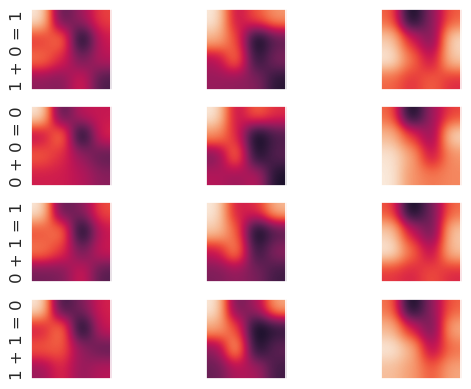

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# load X_conv and y_conv
Xconv_load   = np.load('X_conv.npz',allow_pickle=True)
yconv_load   = np.load('y_conv.npz',allow_pickle=True)

Xconv = Xconv_load['arr_0'].astype('float64')
yconv = yconv_load['arr_0'].astype('float64')

# set up the training and test samples
percent_train = 0.9
num_train = int(np.round(Xconv.shape[0]*0.8))
num_test  = Xconv.shape[0]-num_train
Xtrain    = Xconv[0:num_train]
ytrain    = yconv[0:num_train]
def show_kernels(num_kernels,frame_rows,frame_cols):
    kernels = pd.read_csv('kernels.csv').to_numpy()
    kernels = kernels.reshape(num_kernels,frame_rows,frame_cols)

    num_plot_rows = round(num_kernels/3.0)+1
    num_plot_cols = 3
    fig, axes = plt.subplots(num_plot_rows,num_plot_cols)
    for i, ax in enumerate(axes.flat):
        if (i<num_kernels):
            ax.imshow(kernels[i],interpolation='gaussian')
            ax.grid(None)
    plt.show()

kernels = pd.read_csv('kernels.csv').to_numpy()
num_kernels = kernels.shape[0]

frame_rows = 2
frame_cols = 2
def capture_frames(image,frame_rows,frame_cols):
    image_rows = image.shape[0]
    image_cols = image.shape[1]
    frame_pos_horz = image_cols-frame_cols+1
    frame_pos_vert = image_rows-frame_rows+1
    captured_frames = np.zeros((frame_pos_horz*frame_pos_vert, \
                                   frame_rows,frame_cols))
    for i in range(frame_pos_horz):
        for j in range(frame_pos_vert):
            single_frame = image[i:i+frame_rows,j:j+frame_cols]
            captured_frames[frame_pos_vert*i+j,:,:]=single_frame
    return captured_frames.reshape(frame_pos_horz*frame_pos_vert, \
                                   frame_rows*frame_cols).T

to_plot = np.array([92,90,7993,85])
plot_list  = list()
title_list = list()
for k in range(len(to_plot)):
    current = to_plot[k]
    image = Xtrain[current]
    #print("ytrain: ",ytrain[current].round())
    image_frames = capture_frames(image,frame_rows,frame_cols)

    layer_0_pre = np.zeros((num_kernels,image_frames.shape[1]))
    for k in range(num_kernels):
        layer_0_pre[k,:]= \
            np.matmul(kernels[k].reshape(1,len(kernels[k])), \
                      image_frames)
        
    image_rows = image.shape[0]
    image_cols = image.shape[1]
    filtered_rows = image_rows-frame_rows+1
    filtered_cols = image_cols-frame_cols+1
    filtered_img = layer_0_pre.reshape(num_kernels,filtered_rows, \
                                                   filtered_cols)
    plot_list.append(filtered_img)
    name = str(ytrain[current][0:2].round().argmax()) + str(" + ") + \
           str(ytrain[current][2:4].round().argmax()) + str(" = ") + \
           str(ytrain[current][4:6].round().argmax())
    title_list.append(name)
    
%matplotlib inline
num_plot_rows = 4
num_plot_cols = 3
fig, axes = plt.subplots(num_plot_rows,num_plot_cols)
for i, ax in enumerate(axes.flat):
    current_row = int(i/num_plot_cols)
    current_col = i%num_plot_cols
    current_image = plot_list[current_row]
    ax.imshow(current_image[current_col],interpolation='gaussian')
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    if (current_col==0):
       ax.set_ylabel(title_list[current_row])
    ax.grid(None)

The differences in the filtered activations across the operations are subtle. For example, the lower left corner of the leftmost kernel is darker for "1 + 0 = 1" and "0 + 1 = 1" than for "0 + 0 = 0" or "1 + 1 = 0". Given "heat maps" like these, perhaps it would be possible to label the internal states similarly to how we might hope to determine what a human is perceiving and thinking on the basis of functional MRI images.